In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from pmdarima.arima import auto_arima
import multiprocessing as mp
import saxpy
from saxpy.sax import sax_via_window
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [271]:
data = df2.drop("DATETIME",1)

dfy = df2["ATT_FLAG"]
dfy = dfy.replace(-999,0)
x = []
x = pd.DataFrame(x)
for index in range(0,len(data.columns)):
    indexname = "{}".format(data.columns[index])
    dat = data[indexname].values
    amount_of_levels = 3
    window_size = 2

    discrete_signal = []
    for t in range(len(dat)-window_size):
        dat_znorm = znorm(dat[t:t+window_size])
        discrete_signal.append(ts_to_string(dat_znorm, cuts_for_asize(amount_of_levels)))

    x[indexname] = discrete_signal
saxxeddata = x   

In [272]:
saxxeddata = saxxeddata.drop("ATT_FLAG",1)

In [273]:
# saxxeddata["output"] = dfy


In [274]:
targets_for_onehot = saxxeddata.columns
new_df = pd.DataFrame([])

for target in targets_for_onehot:
    temp = pd.get_dummies(saxxeddata[target])
    new_df = pd.concat([new_df, temp],axis=1)



In [275]:
import torch
import torch.nn as nn

In [276]:
# dfy = df2["ATT_FLAG"]
# dfy = dfy.replace(-999,0)
from sklearn.model_selection import train_test_split
data= df2
datay = dfy
data = data.drop("DATETIME",axis=1)
data = data.drop("ATT_FLAG",axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(data, dfy, test_size = 0.2)
xTrain = torch.tensor(xTrain.values,dtype=torch.float)
yTrain = torch.tensor(yTrain.values,dtype=torch.float)
xTest = torch.tensor(xTest.values,dtype=torch.float)
yTest = torch.tensor(yTest.values,dtype=torch.float)


In [283]:

var = df2.drop(["DATETIME","ATT_FLAG"],axis=1).shape[1]
n_in, n_h, n_out, batch_size = var, 5, 1, 5

model = nn.Sequential(nn.Linear(n_in, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_out),
                     nn.Sigmoid())
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lossgraph = []
testlossgraph=[]
for epoch in range(50):
    # Forward Propagation
    y_pred = model(xTrain)
    y_pred_test = model(xTest)
    # Compute and print loss
    loss = criterion(y_pred, yTrain)
    testloss = criterion(y_pred_test,yTest)
    print('Round: ', epoch,' train loss: ', loss.item())
    print("test loss: ", testloss.item())
    
    lossgraph.append(float(loss))
    testlossgraph.append(float(testloss))
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

Round:  0  train loss:  0.1731823831796646
test loss:  0.16720716655254364
Round:  1  train loss:  0.1691511869430542
test loss:  0.16338135302066803
Round:  2  train loss:  0.16529305279254913
test loss:  0.15973451733589172
Round:  3  train loss:  0.16160549223423004
test loss:  0.15623770654201508
Round:  4  train loss:  0.15808266401290894
test loss:  0.15288467705249786
Round:  5  train loss:  0.15470726788043976
test loss:  0.14967751502990723
Round:  6  train loss:  0.15146109461784363
test loss:  0.14659292995929718
Round:  7  train loss:  0.14831727743148804
test loss:  0.14362740516662598
Round:  8  train loss:  0.1452508121728897
test loss:  0.14075176417827606
Round:  9  train loss:  0.14225028455257416
test loss:  0.1379109025001526
Round:  10  train loss:  0.13932345807552338
test loss:  0.13514161109924316
Round:  11  train loss:  0.13647568225860596
test loss:  0.1324581503868103
Round:  12  train loss:  0.13369889557361603
test loss:  0.12985746562480927
Round:  13  tr

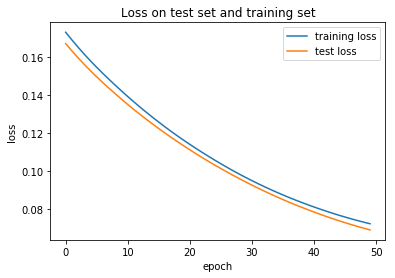

In [284]:
plt.plot(lossgraph,label="training loss")
plt.plot(testlossgraph,label="test loss")
plt.title("Loss on test set and training set")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [285]:
results= []
labels = []
for i in range(0,len(y_pred_test)):
    label = float(yTest[i])
    labels.append(label)
    prediction = float(y_pred_test[i])
    results.append(prediction)

In [290]:
results = pd.DataFrame(results)
results.head()

,0,labels
0,0.000675,0.0
1,0.046628,0.0
2,0.014012,0.0
3,0.527463,0.0
4,0.004630,0.0


In [291]:
results["labels"] = pd.DataFrame(labels)

In [315]:

average = results[0].sum()/len(results)
precision = results["labels"].sum()/len(labels)

classified = results[results[0] > average]
classified = classified["labels"].sum()
recall = classified/results["labels"].sum()

print("Precision is: ", precision)
print("Recall is: ", recall)

Precision is:  0.050239234449760764
Recall is:  0.38095238095238093
